obs if you are running this in vscode, you need to select python environment as prolif, and then select the prolif environment as your kernel too 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import prolif as plf
import MDAnalysis as mda
import pandas as pd
import analysis_functions
import seaborn as sns
from typing import Optional

In [2]:
color_l= ["#539C44", "#37456d", "#E27439", "grey"]

# Load unis using analysis scripts

In [3]:
all_unis, all_lens = analysis_functions.load_em_unis()

# Run fp , save df, put in dict

If you don't change anything here you could turn this calculation to false to save time. Right now I have skip50 on to make the calculation smoother

In [4]:
all_fp_dfs = {}
skip = 1

for condition in all_unis.keys():
    # print(condition)
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[condition]):
        if (
            condition != "PfHT_apo"
        ):  ## no need to run fingerprints on sim that doesn't have mmv...
            df = analysis_functions.get_fp_dataframe(
                u=rep_fp,
                skip=skip,
                run_calc=False,
                filename=f"{condition}.replica_{n+1}.skip{skip}",
            )
            temp_fp_dfs.append(df)
    all_fp_dfs[condition] = temp_fp_dfs
all_fp_dfs.pop("PfHT_apo")  ## probably a better way to remove this guy, but that's ok

[]

# Calculate percentage of whatever interaction you want

This was originally for pi stacking with w412 but you could do this with anything now since I realized I will need it for serine 432 and maybe others
Just find where TRP412 (or equivalent) is in the dataframe, then divide sum (since only True or False) by total sim length


save in numpy array called `all_pis` with shape (`[n_conditions], [n_replicas]`)

In [5]:
def percentage_specific_intxn_all_sims(
        PfHT_residue_number: str,
        GLUT1_residue_number: str,
        interaction_name: str,
        all_fp_dfs: dict = all_fp_dfs,
        n_conditions: int = 4,
        n_reps: int = 3
) -> np.array: 
    """
    Will read the dict of fingerprints, condition by condition, for each replica
    Find percentage of True in each df
    Will return a np array with shape (n_conditions, n_reps) (4,3) currently

    """   
    
    all_percentages = np.zeros((n_conditions, n_reps))

    for cond_index, condition in enumerate(all_fp_dfs.keys()):
        for rep_index, replica in enumerate(all_fp_dfs[condition]):
            if "GLUT1" in condition:
                try:
                    percent_True = (replica[GLUT1_residue_number][interaction_name].sum()) / len(replica)
                except KeyError:  # if there is never pi stacking, won't find it in the df
                    percent_True = 0

            else:
                try:
                    percent_True = (replica[PfHT_residue_number][interaction_name].sum()) / len(replica)
                except KeyError:  # if there is never pi stacking, won't find it in the df
                    percent_True = 0


            all_percentages[cond_index, rep_index] = percent_True
    
    return all_percentages

#### function to plot grouped barplot for this

In [6]:
def plot_grouped_barplot(
        percentage_array: np.array,
        ax: plt.axes,
        intxn_name: str,
        all_fp_dfs: dict = all_fp_dfs
) -> plt.axes:

    x = np.arange(np.shape(percentage_array)[0])
    width = 0.2
    ax.bar(x - 0.2, percentage_array[:, 0], width, color=color_l)
    ax.bar(x, percentage_array[:, 1], width, color=color_l, alpha = 0.8)
    ax.bar(x + 0.2, percentage_array[:, 2], width, color=color_l, alpha = 0.6)

    ax.set_xticks(x, all_fp_dfs.keys())
    ax.set_xlabel("Condition")
    ax.set_ylabel(f"Percent {intxn_name} in sim")
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
    #ax.legend(["Rep 1", "Rep 2", "Rep 3"])

# calculate interactions

Or other calcs now possible here too

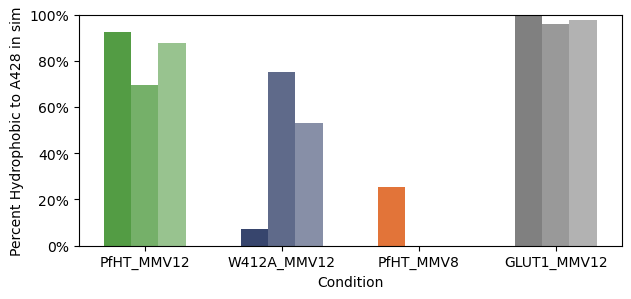

In [7]:
## actual #: [PfHT tpr #, GLUT1 tpr #, intxn name]
res_num_map = {
    'W412':['TRP391', 'TRP381', 'PiStacking'], 
    'S432':['SER411', 'GLY401', 'HBAcceptor'],
    'Q169':['GLN148', 'GLN154', 'HBAcceptor'],
    'D425':['ASP404', 'PRO394', 'HBDonor'],
    'P149':['PRO128', 'PRO134', 'Hydrophobic'],
    'H168':['HSD147','HSD153', 'Hydrophobic'],
    'A428':['ALA407', 'ILE397', 'Hydrophobic']
            
            }

res = 'A428'

intxn = percentage_specific_intxn_all_sims(
    PfHT_residue_number=res_num_map[res][0],
    GLUT1_residue_number=res_num_map[res][1],
    interaction_name=res_num_map[res][2]
)

f,ax = plt.subplots(1,1, figsize=(7,3))
plot_grouped_barplot(
    percentage_array=intxn, 
                     ax=ax,
                     intxn_name=f'{res_num_map[res][2]} to {res}'
                     )


#### s432 h bonding

# sandbox again

In [8]:
# keep for now, will remove after I validate Ivens code

def get_all_mean_intxn_time_dfs_wide(
    intxn_name: str,
    mean_cutoff: float=0.1,    
    all_fp_dfs: dict=all_fp_dfs
) -> pd.DataFrame:
    """
    Calculates the mean interaction time for a specified interaction type
    Returns a multilevel dataframe with residue interacting as the index,
      and replica #(python indexed) as the column name, for each condition multi index
      this is in wide format, but we need to be able to keep Nans in place for ensuring that zeros
      are counted

      Intention is therefore to drop GLUT1 from this dataframe, and then melt along residues
      to get a long form dataframe
    """

    all_mean_interactions = {}
    for condition in all_fp_dfs.keys():
        mean_intxn_all_reps = []
        for rep in all_fp_dfs[condition]:
            intxn_group_over_time = rep.xs(intxn_name, level="interaction", axis=1)
            mean_intxn = intxn_group_over_time.mean()
            mean_intxn = mean_intxn.loc[mean_intxn>mean_cutoff]
            mean_intxn_all_reps.append(mean_intxn)
        mean_intxn_all_reps = pd.concat(mean_intxn_all_reps, axis=1, keys=[f'replica 1', 'replica 2', 'replica 3'])
        all_mean_interactions[condition] = mean_intxn_all_reps

    all_mean_interactions = pd.concat(all_mean_interactions, axis=1)

    return all_mean_interactions


In [50]:
def process_wide_df(
  df: pd.DataFrame,
  index_col_name: str,
  condition_to_remove: Optional[str] = None,
  index_name: str='index',
  top_level_melt_name: str='protein',
  lower_level_melt_name: str='replica',
  add_21: bool=False
) -> pd.DataFrame:
  """
  Wide multi index dataframe as input with the following format:
  eventual label as index (ie residue name)
  condition name as top label
  replica name as under label 
  This isn't strictly necessary but it is designed this way because
  other functions make dataframes like this
  ie: 
  index:              PfHT_MMV12     ... GLUT1_MMV12
          replica 1:   replica 2:         replica 3:
  GLN104     value1       value3            value500
  ASP205     value2       value4

  is a typical format for input
  and output will be like:
         value:     replica:   protein:    residue:
  0      value1     replica1    PfHT_MMV12   GLN104
  1      value3     replica2    PfHT_MMV12   GLN104
  ...
  20     value2     replica3   PfHT_MMV12   ASP205


  will melt array and rename the index to the variable 'index_col_name'
  (this might be residue, n_interactions...). If index is from prolif
  directly, it's probably named "protein"


  """
  ## sometimes there might be values specific only to the 
  ### condition you want to remove, so drop these from the dataframe
  if condition_to_remove is not None:
    del df[condition_to_remove]
    df = df.dropna(how='all', axis=0) 


  ## for the melting, if you have gathered replicas together, and then
  #### gathered conditions on top of that (as is often the structure of other 
  ##### functions of this script), the top_level_melt_name is usually 'protein'
  ###### and lower_level_melt_name is 'residue'
  df = (df.fillna(0.0)
  .reset_index()
  .rename({index_name:index_col_name}, axis=1)
  .melt(id_vars=[index_col_name], var_name=[top_level_melt_name, lower_level_melt_name])
  )

  ### finally, add 21 to res numbers
  ## TODO - conditional if PfHT
  if add_21:
    df['resnr']= df['residue'].str[3:].astype(int)+21
    df['residue']= df['residue'].str[:3]+df['resnr'].astype(str)
    del df['resnr']

  return df

In [51]:
intxn_name = 'HBAcceptor'
all_mean_interactions = get_all_mean_intxn_time_dfs_wide(
    intxn_name=intxn_name
)

all_mean_interactions= process_wide_df(
    df= all_mean_interactions,
    index_col_name= 'residue',
    condition_to_remove= 'GLUT1_MMV12',
    index_name= 'protein',
    top_level_melt_name= 'protein', #put condition names together in col called protein
    lower_level_melt_name= 'replica',  # put replica columns together into one column called replica
    add_21= True
)

/tmp/ipykernel_663209/365372372.py:11: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.stripplot(data=all_mean_interactions,


(0.0, 1.1)

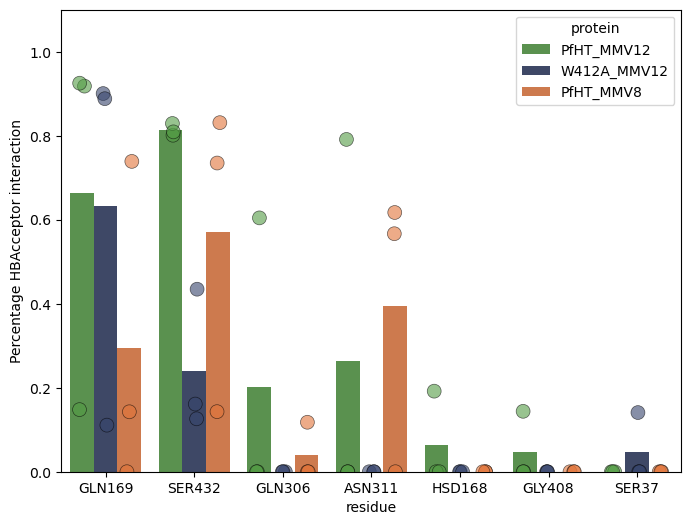

In [10]:
f,ax = plt.subplots(1,1, figsize=(8,6))
sns.barplot(data=all_mean_interactions, 
            x='residue',
            y='value',
            hue= 'protein',
            errorbar= None,
            ax= ax,
            palette= color_l
            )

sns.stripplot(data=all_mean_interactions, 
            x='residue',
            y='value',
            hue= 'protein',
            ax= ax,
            dodge=True,
            alpha= 0.6,
            edgecolor='black',
            linewidth=0.5,
            legend=False,
            size=10,
            palette= color_l
            )

ax.set_ylabel(f"Percentage {intxn_name} interaction")
ax.set_ylim(0,1.1)

In [34]:
temp_all = {}
for name, fp_df_l in all_fp_dfs.items():
    temp_rep = []
    for rep_n, rep_df in enumerate(fp_df_l):
        n_counts = rep_df.xs('HBAcceptor', level='interaction', axis=1).sum(axis=1).value_counts()
        n_counts.name= f'replica {rep_n+1}'
        temp_rep.append(n_counts)
    temp_rep = pd.concat(temp_rep, axis=1)
    temp_all[name] = temp_rep
    
temp_all= pd.concat(temp_all, axis=1)

In [37]:
temp_all.reset_index()

index PfHT_MMV12                     W412A_MMV12                      \
         replica 1 replica 2 replica 3   replica 1 replica 2 replica 3   
0     2        682       202     348.0       136.0     198.0     169.0   
1     1        167        37     538.0       751.0     496.0     657.0   
2     3        122       267      35.0        25.0       8.0      10.0   
3     0         18         6      77.0        70.0     299.0      58.0   
4     4         11       458       3.0         2.0       NaN       NaN   
5     5          1        31       NaN         NaN       NaN       NaN   

  PfHT_MMV8                     GLUT1_MMV12                      
  replica 1 replica 2 replica 3   replica 1 replica 2 replica 3  
0      32.0     345.0     513.0        24.0      52.0     204.0  
1     189.0     127.0     304.0       234.0     450.0     425.0  
2       3.0     355.0      30.0         3.0       2.0      29.0  
3     664.0      21.0      36.0       646.0     351.0     227.0  
4       NaN      52.0       NaN         NaN       NaN       1.0  
5       NaN       NaN       NaN         NaN       NaN       NaN

In [30]:
intxn_name = 'HBAcceptor'
all_mean_interactions = get_all_mean_intxn_time_dfs_wide(
    intxn_name=intxn_name
)

In [31]:
all_mean_interactions

PfHT_MMV12                     W412A_MMV12                      \
         replica 1 replica 2 replica 3   replica 1 replica 2 replica 3   
protein                                                                  
GLN148    0.918082  0.925075  0.147852    0.900407  0.110889  0.888143   
SER411    0.801199  0.829171  0.809191    0.126016  0.434565  0.161074   
GLN285         NaN  0.604396       NaN         NaN       NaN       NaN   
ASN290         NaN  0.791209       NaN         NaN       NaN       NaN   
HSD147         NaN       NaN  0.191808         NaN       NaN       NaN   
GLY387         NaN       NaN  0.143856         NaN       NaN       NaN   
SER16          NaN       NaN       NaN         NaN  0.140859       NaN   
GLN154         NaN       NaN       NaN         NaN       NaN       NaN   
GLN276         NaN       NaN       NaN         NaN       NaN       NaN   
TYR285         NaN       NaN       NaN         NaN       NaN       NaN   
ASN408         NaN       NaN       NaN         NaN       NaN       NaN   

        PfHT_MMV8                     GLUT1_MMV12                      
        replica 1 replica 2 replica 3   replica 1 replica 2 replica 3  
protein                                                                
GLN148        NaN  0.738889  0.142695         NaN       NaN       NaN  
SER411   0.143018  0.831111  0.734994         NaN       NaN       NaN  
GLN285        NaN  0.117778       NaN         NaN       NaN       NaN  
ASN290        NaN  0.566667  0.617214         NaN       NaN       NaN  
HSD147        NaN       NaN       NaN         NaN       NaN       NaN  
GLY387        NaN       NaN       NaN         NaN       NaN       NaN  
SER16         NaN       NaN       NaN         NaN       NaN       NaN  
GLN154        NaN       NaN       NaN         NaN  0.538012       NaN  
GLN276        NaN       NaN       NaN         NaN       NaN  0.146727  
TYR285        NaN       NaN       NaN         NaN       NaN  0.124153  
ASN408        NaN       NaN       NaN         NaN       NaN  0.568849

In [138]:
'''
def get_all_mean_intxn_times(
        intxn_name: str, 
        mean_cutoff: float=0.1,
        all_fp_dfs: dict=all_fp_dfs
) -> pd.DataFrame:
    """
    Caculates mean interaction time for a specified interaction
    Make the dataframe into long form so we can easily read with seaborn later
    (or to change data easily)

    Will return a longform df with:
    plain number index
    columns: residue name, value (mean intxn time), protein(sim name), replica (rep #)
    """

    all_dfs = []
    for sim_name, df_list in all_fp_dfs.items():
        for rep_index, rep_fp in enumerate(df_list):
            rep_fp = rep_fp.xs(intxn_name, level="interaction", axis=1) #cross section of intxn desired
            mean_df = (
                rep_fp.mean()    
                .rename("value")
                .reset_index()
                .rename({"protein": "residue"}, axis=1)
            )
            mean_df = mean_df.loc[mean_df['value'] > mean_cutoff] # filter out means which are quite small
            mean_df["protein"] = sim_name
            mean_df["replica"] = rep_index + 1
            all_dfs.append(mean_df)

    all_dfs = pd.concat(all_dfs).reset_index(drop=True)
    return all_dfs

'''